# Postprocessing: data quality check using the analysis
In this notebook we explain how the analysis itself can be used to get an indication of the data quality.

In [87]:
using DIVAnd
using PyPlot
using Dates
using Statistics

## Data reading
Salinity observations are read from a netCDF file based on the [World Ocean Database](https://www.nodc.noaa.gov/OC5/WOD/pr_wod.html).     
The reading is done using `loadobs` function.

In [88]:
varname = "Salinity"
filename = "data/WOD-Salinity-Provencal.nc"

if !isfile(filename)    
    download("https://dox.ulg.ac.be/index.php/s/PztJfSEnc8Cr3XN/download",filename)
end

obsval,obslon,obslat,obsdepth,obstime,obsid = loadobs(Float64,filename,"Salinity");

### Topography and grid definition

See the [topography notebook](06-topography.ipynb) for more details.     
Here the code is just replicated to get topography defining the mask.

In [89]:
dx = dy = 0.05
lonr = 2.5:dx:12.
latr = 41.9:dy:44.6

mask,(pm,pn),(xi,yi) = DIVAnd_rectdom(lonr,latr)

bathname = "data/gebco_30sec_4.nc"

if !isfile(bathname)
    download("https://dox.ulg.ac.be/index.php/s/RSwm4HPHImdZoQP/download",bathname)
else
    @info("Bathymetry file already downloaded")
end

bx,by,b = load_bath(bathname,true,lonr,latr)

mask = falses(size(b,1),size(b,2))

for j = 1:size(b,2)
    for i = 1:size(b,1)
        mask[i,j] = b[i,j] >=1.0
    end
end

┌ Info: Bathymetry file already downloaded
└ @ Main In[89]:12


### Data selection for example

Cross validation, error calculations etc. assume independant data. Hence do not take high-resolution vertical profiles with all data but restrict yourself to specific small depth range. Here August data at surface:

In [90]:
sel = (obsdepth .< 1) .& (Dates.month.(obstime) .== 8)

obsval = obsval[sel]
obslon = obslon[sel]
obslat = obslat[sel]
obsdepth = obsdepth[sel]
obstime = obstime[sel]
obsids = obsid[sel];
@show (size(obsval))
checkobs((obslon,obslat,obsdepth,obstime),obsval,obsid)

size(obsval) = (1956,)
              minimum and maximum of obs. dimension 1: (3.0763332843780518, 11.779999732971191)
              minimum and maximum of obs. dimension 2: (42.0, 44.0)
              minimum and maximum of obs. dimension 3: (0.0, 0.9921539425849915)
              minimum and maximum of obs. dimension 4: (1910-08-09T00:00:00, 2014-08-28T19:36:00)
                          minimum and maximum of data: (24.886999130249023, 39.18000030517578)


┌ Info: Checking ranges for dimensions and observations
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/obsstat.jl:75


### Analysis

Analysis parameters have been calibrated in the other notebook example.     
Analysis `fi` using mean data as background.      
Structure `s` is stored for later use.

In [91]:
len=0.5
epsilon2=5.0
fi,s = DIVAndrun(mask,(pm,pn),(xi,yi),(obslon,obslat),obsval.-mean(obsval),len,epsilon2);

Plot of the gridded field and the observations.

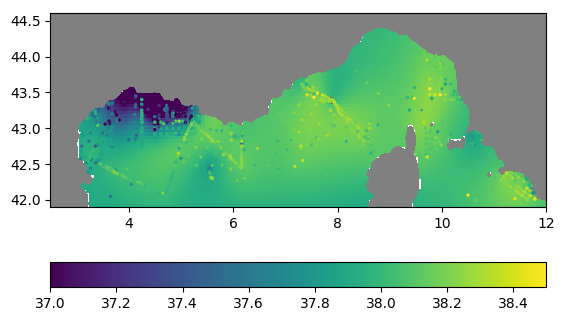

In [92]:
pcolor(xi,yi,fi.+mean(obsval),vmin=37,vmax=38.5);
colorbar(orientation="horizontal")
contourf(bx,by,copy(b'), levels = [-1e5,0],colors = [[.5,.5,.5]])
gca().set_aspect(1/cos(mean([ylim()...]) * pi/180))
scatter(obslon,obslat,s=2,c=obsval,vmin=37,vmax=38.5);

Plot of the data residuals

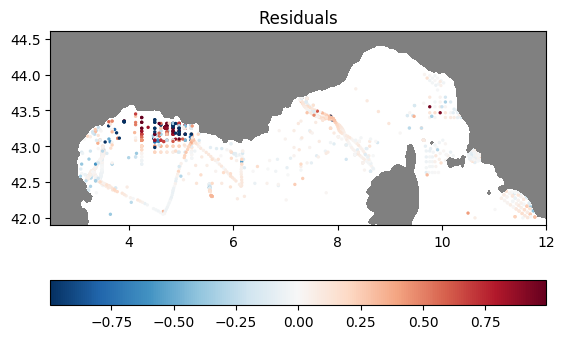

In [93]:
dataresiduals=DIVAnd_residualobs(s,fi)
rscale=sqrt(var(obsval))
scatter(obslon,obslat,s=2,c=dataresiduals,vmin=-rscale,vmax=rscale,cmap=ColorMap("RdBu_r"));
colorbar(orientation="horizontal")
contourf(bx,by,copy(b'), levels = [-1e5,0],colors = [[.5,.5,.5]])
gca().set_aspect(1/cos(mean([ylim()...]) * pi/180))
title("Residuals");

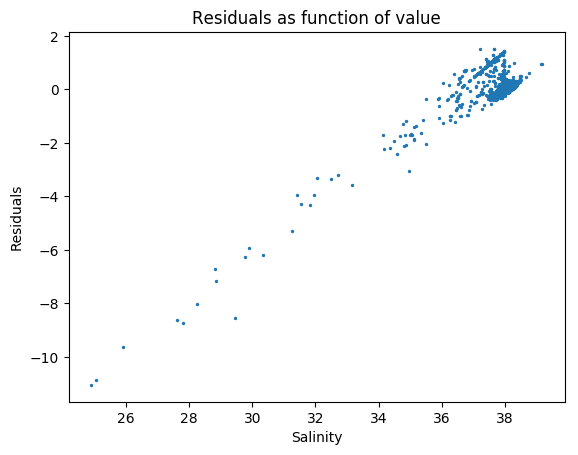

In [94]:
figure()
scatter(obsval,dataresiduals, s=2)
xlabel("Salinity")
ylabel("Residuals")
title("Residuals as function of value");

# Data quality check

As for cross validation, in theory take out data and measure the difference between these data points not used and the analysis. Can be done without actually taking out the points. Three methods are implemented.
## Define method used
The different methods are described as the output of 
```julia
?DIVAnd_qc
```
Here we use the method 1: standard cross validation.    
The suspect data points are considered as those with a QC value higher than 10.

In [ ]:
qcval=DIVAnd_qc(fi,s,1)

# Find suspect points
sp=findall(x-> x.>10,qcval)

# Or sort the indicator
suspectindexes=sortperm(qcval,rev=true);

The suspect points are characterised by a lower salinity and are mostly located in the [Rhône](https://en.wikipedia.org/wiki/Rh%C3%B4ne) estuary.

In [ ]:
scatter(obsval,dataresiduals,c=qcval,vmin=1,vmax=10)
colorbar(orientation="horizontal")
title("Residuals as function of value,\n colored by the QC value");

In [ ]:
pcolor(xi,yi,fi.+mean(obsval),vmin=37,vmax=38.5);
colorbar(orientation="horizontal")
contourf(bx,by,copy(b'), levels = [-1e5,0],colors = [[.5,.5,.5]])
gca().set_aspect(1/cos(mean([ylim()...]) * pi/180))

scatter(obslon[sp],obslat[sp],s=2,c="red")
title("Position of suspect points");

### More information

In [ ]:
?DIVAnd_qc

## Exercise

* Redo for different data.
* Possibly force the cross-validation method (use ?DIVAnd_cv)
* Once opimized, try to redo optimization with starting point being the first estimate+
* Change level for qc parameter used for flagging
* Create non-uniform weights for data using the quality check parameter. Then redo the analysis and possibly the whole chain from analysis, calibration

## ⚠️ Important note
Data quality check using analysis-data misfits is usefull but should not replace PREPROCESSING quality checks and proper quality flag exploitation.